Silhouette Score: 0.910
Davies-Bouldin Index: 0.436


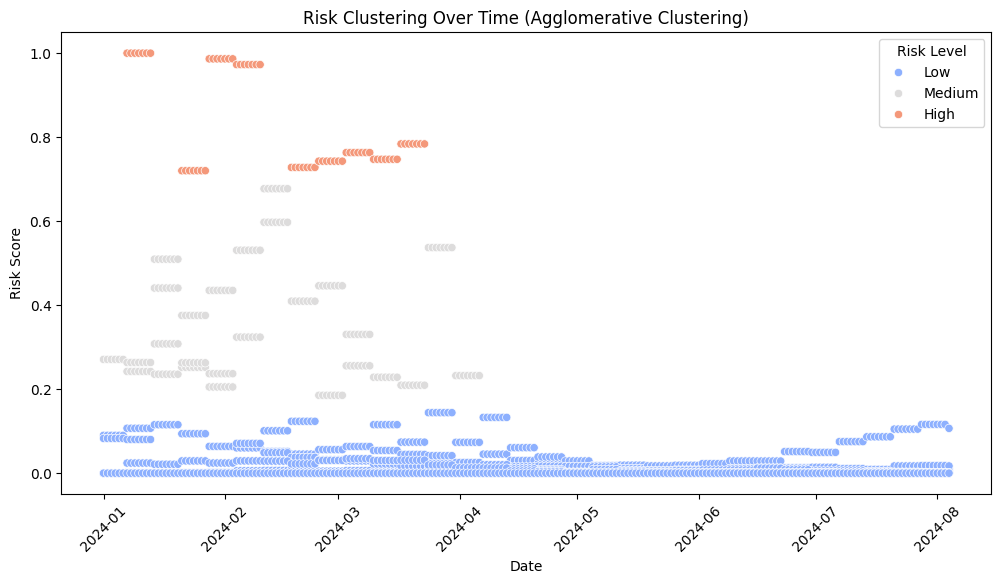

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Load dataset
filepath = "owid-covid-data.csv"
df = pd.read_csv(filepath)

# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"])

# Filter for South America & Year 2024
df = df[(df["continent"] == "South America") & (df["date"].dt.year == 2024)]

# Select necessary columns
features = ["new_cases_smoothed"]
df = df[["location", "date"] + features]

# Normalize new_cases_smoothed to 0-1 range
scaler = MinMaxScaler()
df["risk_score"] = scaler.fit_transform(df[["new_cases_smoothed"]])

# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage="ward")
df["risk_cluster"] = agg_clustering.fit_predict(df[["risk_score"]])

# Dynamically assign cluster labels based on risk score means
cluster_means = df.groupby("risk_cluster")["risk_score"].mean().sort_values()
risk_mapping = {cluster_means.index[0]: "Low", cluster_means.index[1]: "Medium", cluster_means.index[2]: "High"}
df["risk_zone"] = df["risk_cluster"].map(risk_mapping)

# Drop numerical cluster column
df.drop(columns=["risk_cluster"], inplace=True)

# Save final dataset
df.to_csv("new_risk_classification_hierarchical.csv", index=False)

# Metrics Calculation
sil_score = silhouette_score(df[["risk_score"]], df["risk_zone"].astype("category").cat.codes)
db_index = davies_bouldin_score(df[["risk_score"]], df["risk_zone"].astype("category").cat.codes)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")

# Visualization: Risk Clustering Over Time
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="date", y="risk_score", hue="risk_zone", palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Risk Clustering Over Time (Agglomerative Clustering)")
plt.xlabel("Date")
plt.ylabel("Risk Score")
plt.legend(title="Risk Level")
plt.show()
